In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
#importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import time
import datetime
from datetime import datetime

import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')


In [ ]:
#reading the data set
#test = pd.read_csv('../input/covid19-global-forecasting-week-2/test.csv')
#train = pd.read_csv('../input/covid19-global-forecasting-week-2/train.csv')
test = pd.read_csv("../input/covid19-global-forecasting-week-4/test.csv")
train = pd.read_csv("../input/covid19-global-forecasting-week-4/train.csv")
df_pop = pd.read_csv('../input/population-by-country-2020/population_by_country_2020.csv')
covid_pop = pd.read_csv('../input/covid19-global-forecasting-locations-population/locations_population.csv')

## exploring the data set

In [ ]:
display(train.describe())
display(train.tail(5))
display(train.shape)
train[['Province_State','Country_Region','Date']].describe()

In [ ]:
print("Max Date: ", max(train['Date']), ", Min Date: ", min(train['Date']))
print("Max Id: ", max(train['Id']), ", Unique Ids: ", train['Id'].nunique())
print("Max Date: ", max(test['Date']), ", Min Date: ", min(test['Date']))

In [ ]:
train.isnull().sum()

> *Data Set Summary (this should be updated on the day you run this as the data set is live )*
* size of the data set : 19404, 6
* 173 unique countries
* 125 unique Provice_states (11154 null records)
* data for 66 days from 22-Jan-2020 to 27-Mar-2020

## Exploratory Analysis starts from here

In [ ]:
#plotting the daily trend
ww_df = train.groupby('Date')[['ConfirmedCases', 'Fatalities']].sum().reset_index()
# shift is used to take the previous value
ww_df['New_Cases'] = ww_df['ConfirmedCases'] - ww_df['ConfirmedCases'].shift(1)
#ww_df.tail()
#pd.melt is used to create a simillar table like a pivot in excel

trend_df = pd.melt(ww_df, id_vars=['Date'], value_vars=['ConfirmedCases', 'Fatalities', 'New_Cases'])
trend_df.head(5)

fig = px.line(trend_df, x="Date", y="value", color='variable', title="Worldwide Confirmed/Death trend")
fig.show()

In [ ]:
plt.style.use(['tableau-colorblind10'])

#plotting the top 8 Countries with most Fatalities as per latest day

df_Country = train.groupby(['Country_Region'])[["Fatalities","ConfirmedCases"]].max().nlargest(8,'Fatalities')
#df_Country = train[train['Date']=='2020-03-31'].groupby(['Country_Region'])[["Fatalities","ConfirmedCases"]].sum().nlargest(8,'Fatalities')
#bycountry = train.groupby('Country_Region')['Fatalities'].max().sort_values(ascending=False).to_frame().reset_index()

#fatality % = Fatality_Count / Confirmed_Count

df_Country['Fatality_Percentage'] = df_Country['Fatalities']/ df_Country['ConfirmedCases']
df_Country = df_Country.reset_index()
df_Country.sort_values('Fatality_Percentage',inplace=True)
figure, axes = plt.subplots(1, 2,figsize=(12,4))
df_Country.plot(ax= axes[0],x = 'Country_Region', y = ["Fatalities","ConfirmedCases"],kind='bar', title = 'Fatalities Vs Confirmed')
df_Country.plot(ax= axes[1],x = 'Country_Region', y = ["Fatality_Percentage"],kind='bar', title = 'Fatalities divided by Confirmed')

Need to check how rapidly Fatalities are happenning in each country. For this I got the First Fatal Date, Last Fatal Date. The difference between those 2 values give us the no.of the days the country has been in the Fatality Status. Dividing the Fatal count by this number of Fatal Days give the fatal rate.

In [ ]:
#getting the dates with at least 1 Fatality and atleast 1 confirmed case separately
cond1 = train.Fatalities >=1
cond2 = train.ConfirmedCases >= 1
train_Fatal = train[['Country_Region','Date']][(cond1)]
train_Confirm = train[['Country_Region','Date']][(cond2)]

#getting the 1st Confirmed case date for each country
Confirm_Min_Max = train_Confirm.groupby("Country_Region", as_index=False)["Date"].agg(["min","max"])

#getting the 1st Fatality date for each country
Fatal_Min_Max = train_Fatal.groupby("Country_Region", as_index=False)["Date"].agg(["min","max"])

#left outer join the above 2 dataFrames

Country_Dates = pd.merge(Confirm_Min_Max, Fatal_Min_Max, how='left', on=['Country_Region'])
Country_Dates = Country_Dates.rename(columns={'min_x': 'fst_Confirmed', 'max_x': 'last_Confirmed', 'min_y': 'fst_Fatal','max_y': 'last_Fatal'})
    
#setting a default date for null date values
#should remove null day count to get fatality rate (to avoid Division with nulls)

#Date_Cols = ['fst_Confirmed','last_Confirmed','fst_Fatal','last_Fatal']

#Country_Dates[Date_Cols] = Country_Dates[Date_Cols].fillna(pd.to_datetime('2015-01-01'))

Country_Dates['Fatality_Days'] = pd.to_datetime(Country_Dates['last_Fatal']) - pd.to_datetime(Country_Dates['fst_Fatal'])
Country_Dates = Country_Dates.reset_index()
#Country_Dates.head(5)

In [ ]:
# converting date counts to integer values

Country_Dates['Fatality_Days'] = Country_Dates['Fatality_Days'] / np.timedelta64(1, 'D')

Country_Dates.head(5)

In [ ]:
#consider the country wise fatalities and Confirmed cases

#Country_Counts = train.groupby(['Country_Region'])[["Fatalities","ConfirmedCases"]].sum()
cond1 = train.Date == '2020-04-12'
Country_Counts = train[['Country_Region','Date','Fatalities','ConfirmedCases']][(cond1)]
#Country_Counts = train[train['Date']=='2020-03-31']
#Getting min max dates and counts grouped by country

df_Country2 = pd.merge(Country_Dates, Country_Counts, how='left', on=['Country_Region'])

df_Country2['Fatality_Rate'] = round(df_Country2['Fatalities']/pd.to_numeric(df_Country2['Fatality_Days']),2)
df_Country2['Fatality_Rate'] = round(df_Country2['Fatalities']/pd.to_numeric(df_Country2['Fatality_Days']),2)

#null fatality rates are set as 0
#infinity fatality rates are set as NaN

df_Country2['Fatality_Rate'] = df_Country2['Fatality_Rate'].fillna(0)
df_Country2 = df_Country2.replace([np.inf, -np.inf], np.nan)
#df_Country2['Country_Region'].describe()

#top 8 countries with the largest Fatality Rates

df_Country3 = df_Country2[df_Country2['Fatality_Rate'] > 0].groupby(['Country_Region'])[["Fatality_Rate"]].sum().nlargest(8,'Fatality_Rate')
df_Country3 = df_Country3.reset_index()

Following chart shows the average increment of the fatality count for a day from the 1st fatality identified date

In [ ]:
#df_Country3.head(5)
#df_Country3.plot(x='Country_Region', y= ["Fatality_Rate"], kind = 'bar', title = 'Top 8 countries with largest fatality rate (Fatalities/Day)')

fig = px.bar(df_Country3, x='Country_Region', y='Fatality_Rate',color='Fatality_Rate')
fig.show()

Looking at the above plots, I categorized the countries in to following groups.
* China - As the first outbreak happened in China, this is an exceptional case. Need to be studies separately
* Italy, Spain, USA, France - These are the top 4 countries affected when considered both the Fatality rate, (Fatalities/ Confirmed) rate.
* Netherlands, Iran, UK - These are the remaining countries from the top 8 affected
* Other Countries

### Plotting the Confirmed vs Fatalities trend for top 8 countries

In [ ]:
confirmed_China = train[train['Country_Region']=='China'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_China = train[train['Country_Region']=='China'].groupby(['Date']).agg({'Fatalities':['sum']})
total_China = confirmed_China.join(fatalities_China)

confirmed_Italy = train[train['Country_Region']=='Italy'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_Italy = train[train['Country_Region']=='Italy'].groupby(['Date']).agg({'Fatalities':['sum']})
total_Italy = confirmed_Italy.join(fatalities_Italy)

confirmed_Spain = train[train['Country_Region']=='Spain'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_Spain = train[train['Country_Region']=='Spain'].groupby(['Date']).agg({'Fatalities':['sum']})
total_Spain = confirmed_Spain.join(fatalities_Spain)

confirmed_Iran = train[train['Country_Region']=='Iran'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_Iran = train[train['Country_Region']=='Iran'].groupby(['Date']).agg({'Fatalities':['sum']})
total_Iran = confirmed_Iran.join(fatalities_Iran)

confirmed_France = train[train['Country_Region']=='France'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_France = train[train['Country_Region']=='France'].groupby(['Date']).agg({'Fatalities':['sum']})
total_France = confirmed_France.join(fatalities_France)

confirmed_Netherlands = train[train['Country_Region']=='Netherlands'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_Netherlands = train[train['Country_Region']=='Netherlands'].groupby(['Date']).agg({'Fatalities':['sum']})
total_Netherlands = confirmed_Netherlands.join(fatalities_Netherlands)

confirmed_UK = train[train['Country_Region']=='United Kingdom'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_UK = train[train['Country_Region']=='United Kingdom'].groupby(['Date']).agg({'Fatalities':['sum']})
total_UK = confirmed_UK.join(fatalities_UK)

confirmed_USA = train[train['Country_Region']=='US'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_USA = train[train['Country_Region']=='US'].groupby(['Date']).agg({'Fatalities':['sum']})
total_USA = confirmed_USA.join(fatalities_USA)


In [ ]:
plt.figure(figsize=(24,18))

plt.subplot(3, 3, 1)
total_China.plot(ax=plt.gca(), title='China')
plt.ylabel("Confirmed infection cases", size=13)

plt.subplot(3, 3, 2)
total_Italy.plot(ax=plt.gca(), title='Italy')

plt.subplot(3, 3, 3)
total_Spain.plot(ax=plt.gca(), title='Spain')

plt.subplot(3, 3, 4)
total_Iran.plot(ax=plt.gca(), title='Iran')
plt.ylabel("Confirmed infection cases", size=13)

plt.subplot(3, 3, 5)
total_France.plot(ax=plt.gca(), title='France')

plt.subplot(3, 3, 6)
total_Netherlands.plot(ax=plt.gca(), title='Netherlands')

plt.subplot(3, 3, 7)
total_UK.plot(ax=plt.gca(), title='United Kingdom')
plt.ylabel("Confirmed infection cases", size=13)

plt.subplot(3, 3, 8)
total_USA.plot(ax=plt.gca(), title='USA')

**Observations**
* Above graphs clearly shows that the trend in China is different from the other countries
* All the other countries shows a likely trend. However, considering the slopes of the graphs from visual level it can be oberved that USA is having a higher rate of Confirmed cases over a small time period
* While other countries have gone to the ( I would call it "Red Zone" ) in a regular way ( Confirmed cases have gradually increased ), Iran has entered the "Red Zone" directly. It shows a sudden increment on confirmed cases.

### Population wise, Land Area wise, Urban Population wise, Median Age wise fatality rate and confirmed rate

when going through articles about COVID - 19, following factors in a country was found as factors that are having an impact on COVID-19 outbreak in a country
* Population density
* Age of the infected person
* Urban population - These areas are highly populated with people and high urban population may affect to a high spread 

In [ ]:
#selecting only the needed columns from population 
#df_pop.columns
df_pop_sel = df_pop[['Country (or dependency)','Population (2020)','Density (P/Km²)','Land Area (Km²)','Med. Age','Urban Pop %']]

#renaming the columns
df_pop_sel.columns = ['Country_Region', 'Population (2020)', 'Density (P/Km²)','Land Area (Km²)', 'Med. Age', 'Urban Pop %']

# Remove the % sign from Urban Pop % field
df_pop_sel['Urban Pop %'] = df_pop_sel['Urban Pop %'].str.rstrip('%')

# Replace United States by US
df_pop_sel.loc[df_pop_sel['Country_Region']=='United States', 'Country_Region'] = 'US'

df_country_pop = pd.merge(df_pop_sel, df_Country, how='inner', on=['Country_Region'])
df_country_pop

Let's create the following factors to get an idea about the affect from Population, Population Density, Median Age, Urban population %
* pop_factor - considering the population (Fatalities/ Population) : larger value, larger impact
* Density_factor - considering the population density : 
* age_factor - considering the Median Age
* urban_factor - considering the urban population

I will use only the population factor for demonstration

In [ ]:
df_country_pop["pop_factor_fatal"] = df_country_pop['Fatalities']/df_country_pop['Population (2020)']
df_country_pop["pop_factor_confirmed"] = df_country_pop['ConfirmedCases']/df_country_pop['Population (2020)']
#df_country_pop = df_country_pop.reset_index(drop = True)
df_country_pop.sort_values('pop_factor_fatal',inplace=True)
df_country_pop
df_country_pop.plot(x = 'Country_Region', y = ["pop_factor_fatal","pop_factor_confirmed"],kind='barh', title = 'Fatalities, Confirmed considering population',figsize = (8,4))

### Insights from the EDA ( Exploratory Data Analysis ) as recorded on 4th April 2020

* Confirmed, Fatal and New Counts still shows a upward trend and increasing day by day.
* USA shows the highest confirmed count.
* Italy shows the highest fatal count.
* Italy shows the highest ratio between Fatalities and Confirmed Cases.
* Italy, Spain , USA, France are the top 4 countires with highest fatal rates. Fatal rate is the fatal count per day from the first identified fatal case of that country.
* China's trend is different with the daily trends ( Confirmed and Fatal ) of other countries. This may be becuase the outbreak started and recorded first in China. Therefore, in the modelling part China should be considered separately.
* Italy and Spain have a significant fatal count and a confirmed count when compaired with their population

## Cleansing the data set

In [ ]:
# filtering data before 26th March as for the competition rules for prediction

cond1 = train['Date'] < '2020-04-01'
train_fil = train[(cond1)]
display(train_fil['Date'].max())
display(train_fil['Date'].min())

In [ ]:
display(train_fil.head(5))
display(covid_pop.head(5))

In [ ]:
#preprocessing

train_fil['Date'] = pd.to_datetime(train_fil['Date'])
train_fil['Day_num'] = preprocessing.LabelEncoder().fit_transform(train_fil.Date)
train_fil['Day'] = train_fil['Date'].dt.day
train_fil['Month'] = train_fil['Date'].dt.month
train_fil['Year'] = train_fil['Date'].dt.year

train_fil_copy = train_fil

train_fil['Province_State'].fillna("None", inplace=True)

#Checking null values
train_fil[train_fil.iloc[:,0:].isnull().any(axis = 1)].iloc[:,0:].head()

In [ ]:
# there is a new data set uploaded for population details for covid data set. I am using this for the population data

covid_pop_sel = covid_pop[['Province.State','Country.Region','Population']]
covid_pop_sel['Province.State'].fillna("None", inplace=True)

#Checking null values
covid_pop_sel[covid_pop_sel.iloc[:,0:].isnull().any(axis = 1)].iloc[:,0:].head()

In [ ]:
#joining population details as previously done in EDA

df_train_pop = train_fil.merge(covid_pop_sel, left_on = ['Country_Region','Province_State'], right_on = ['Country.Region','Province.State'], how = 'left')
#df_train_pop[df_train_pop.iloc[:,1:].isnull().any(axis = 1)].iloc[:,1:].head(3)

In [ ]:
display(covid_pop_sel[covid_pop_sel['Country.Region']=='Italy'])
display(train_fil[train_fil['Country_Region']=='Italy'])

In [ ]:
#getting Country_Regions with Null population (These have not joined correctly when used the primary key as Country_Region)
#check = df_train_pop[df_train_pop['Country_Region']=='Canada'][df_train_pop['Population'].isnull()]
df_train_pop['Province_State'][df_train_pop['Population'].isnull()].unique()
df_train_pop.reindex()
#check[check['Date']=='2020-03-25']

In [ ]:
#code to check column wise null count
#pd.DataFrame(population_raw.isnull().sum()).T

#wildcard matching 
#df_pop_sel[df_pop_sel['Country_Region'].str.match('Taiwan')]

In [ ]:
# Replace Country names to match the train data set
#df_pop_sel.loc[df_pop_sel['Country_Region']=='Czech Republic (Czechia)', 'Country_Region'] = 'Czechia'
#df_pop_sel.loc[df_pop_sel['Country_Region']=='Taiwan', 'Country_Region'] = 'Taiwan*'

In [ ]:
#merging the data set again, after mapping the country names
#df_train_pop = train_fil.merge(df_pop_sel, left_on = 'Country_Region', right_on = 'Country_Region', how = 'left')
#df_train_pop[df_train_pop.iloc[:,1:].isnull().any(axis = 1)].iloc[:,1:].head(3)

In [ ]:
df_train_pop[df_train_pop.iloc[:,1:].isnull().any(axis = 1)].iloc[:,1:].head(3)

In [ ]:
#treating null values
df_train_pop['Province.State'].fillna("None", inplace=True)
df_train_pop['Country.Region'].fillna("None", inplace=True)
df_train_pop['Population'] = df_train_pop['Population'].fillna(0)

In [ ]:
#df_train_pop[['Population (2020)', 'Density (P/Km²)', 'Land Area (Km²)', 'Med. Age', 'Urban Pop %']] = df_train_pop[['Population (2020)', 'Density (P/Km²)', 'Land Area (Km²)', 'Med. Age', 'Urban Pop %']].fillna(0)

In [ ]:
missings_count = {col:df_train_pop[col].isnull().sum() for col in df_train_pop.columns}
missings = pd.DataFrame.from_dict(missings_count, orient='index')
print(missings.nlargest(30, 0))

## Developing the model

EDA gives us some clear insights and a better understanding about the dataset. Therefore a better EDA should be done before directly moving to the modelling part. 
Here is how I started with my model...

As this is an epidemic, I searched what are the statistical models used for forecasting in epidemics. I have attached some links that I found useful to understand an epidemic on a statistical background.

* [https://www.sciencedirect.com/science/article/pii/S1755436516300329](http://)
* [https://www.universiteitleiden.nl/binaries/content/assets/science/mi/scripties/statscience/2017-2018/2018_06_29_masterthesis_verkerk.pdf](http://)
* [https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006917](http://)

I found this very interesing visualization for past pandemics.

* https://www.visualcapitalist.com/history-of-pandemics-deadliest/

Some models Used in forecasting epidemics :

* autoregressive integrated moving average (ARIMA) model - accurate only short-term prediction
* generalized linear model (GLM)
* SIR (Susceptible – Infected – Removed) model
* SEIR (Susceptible – Exposed - Infected – Removed) model

## SIR Model

This is a mostly used model to study the behaviour of an epidemic. 
* **S - Susceptible** is a group of people who are vulnerable to exposure with infectious people. They can be patient when the infection happens
* **I - infectious** represents the infected people
* **R - Recovered/ Removed** people get immunity so that they are not susceptible to the same illness anymore

This Model has some extended versions of it like SEIR (Cossidering the Exposed population) and SIRD (Considering the Deaths)

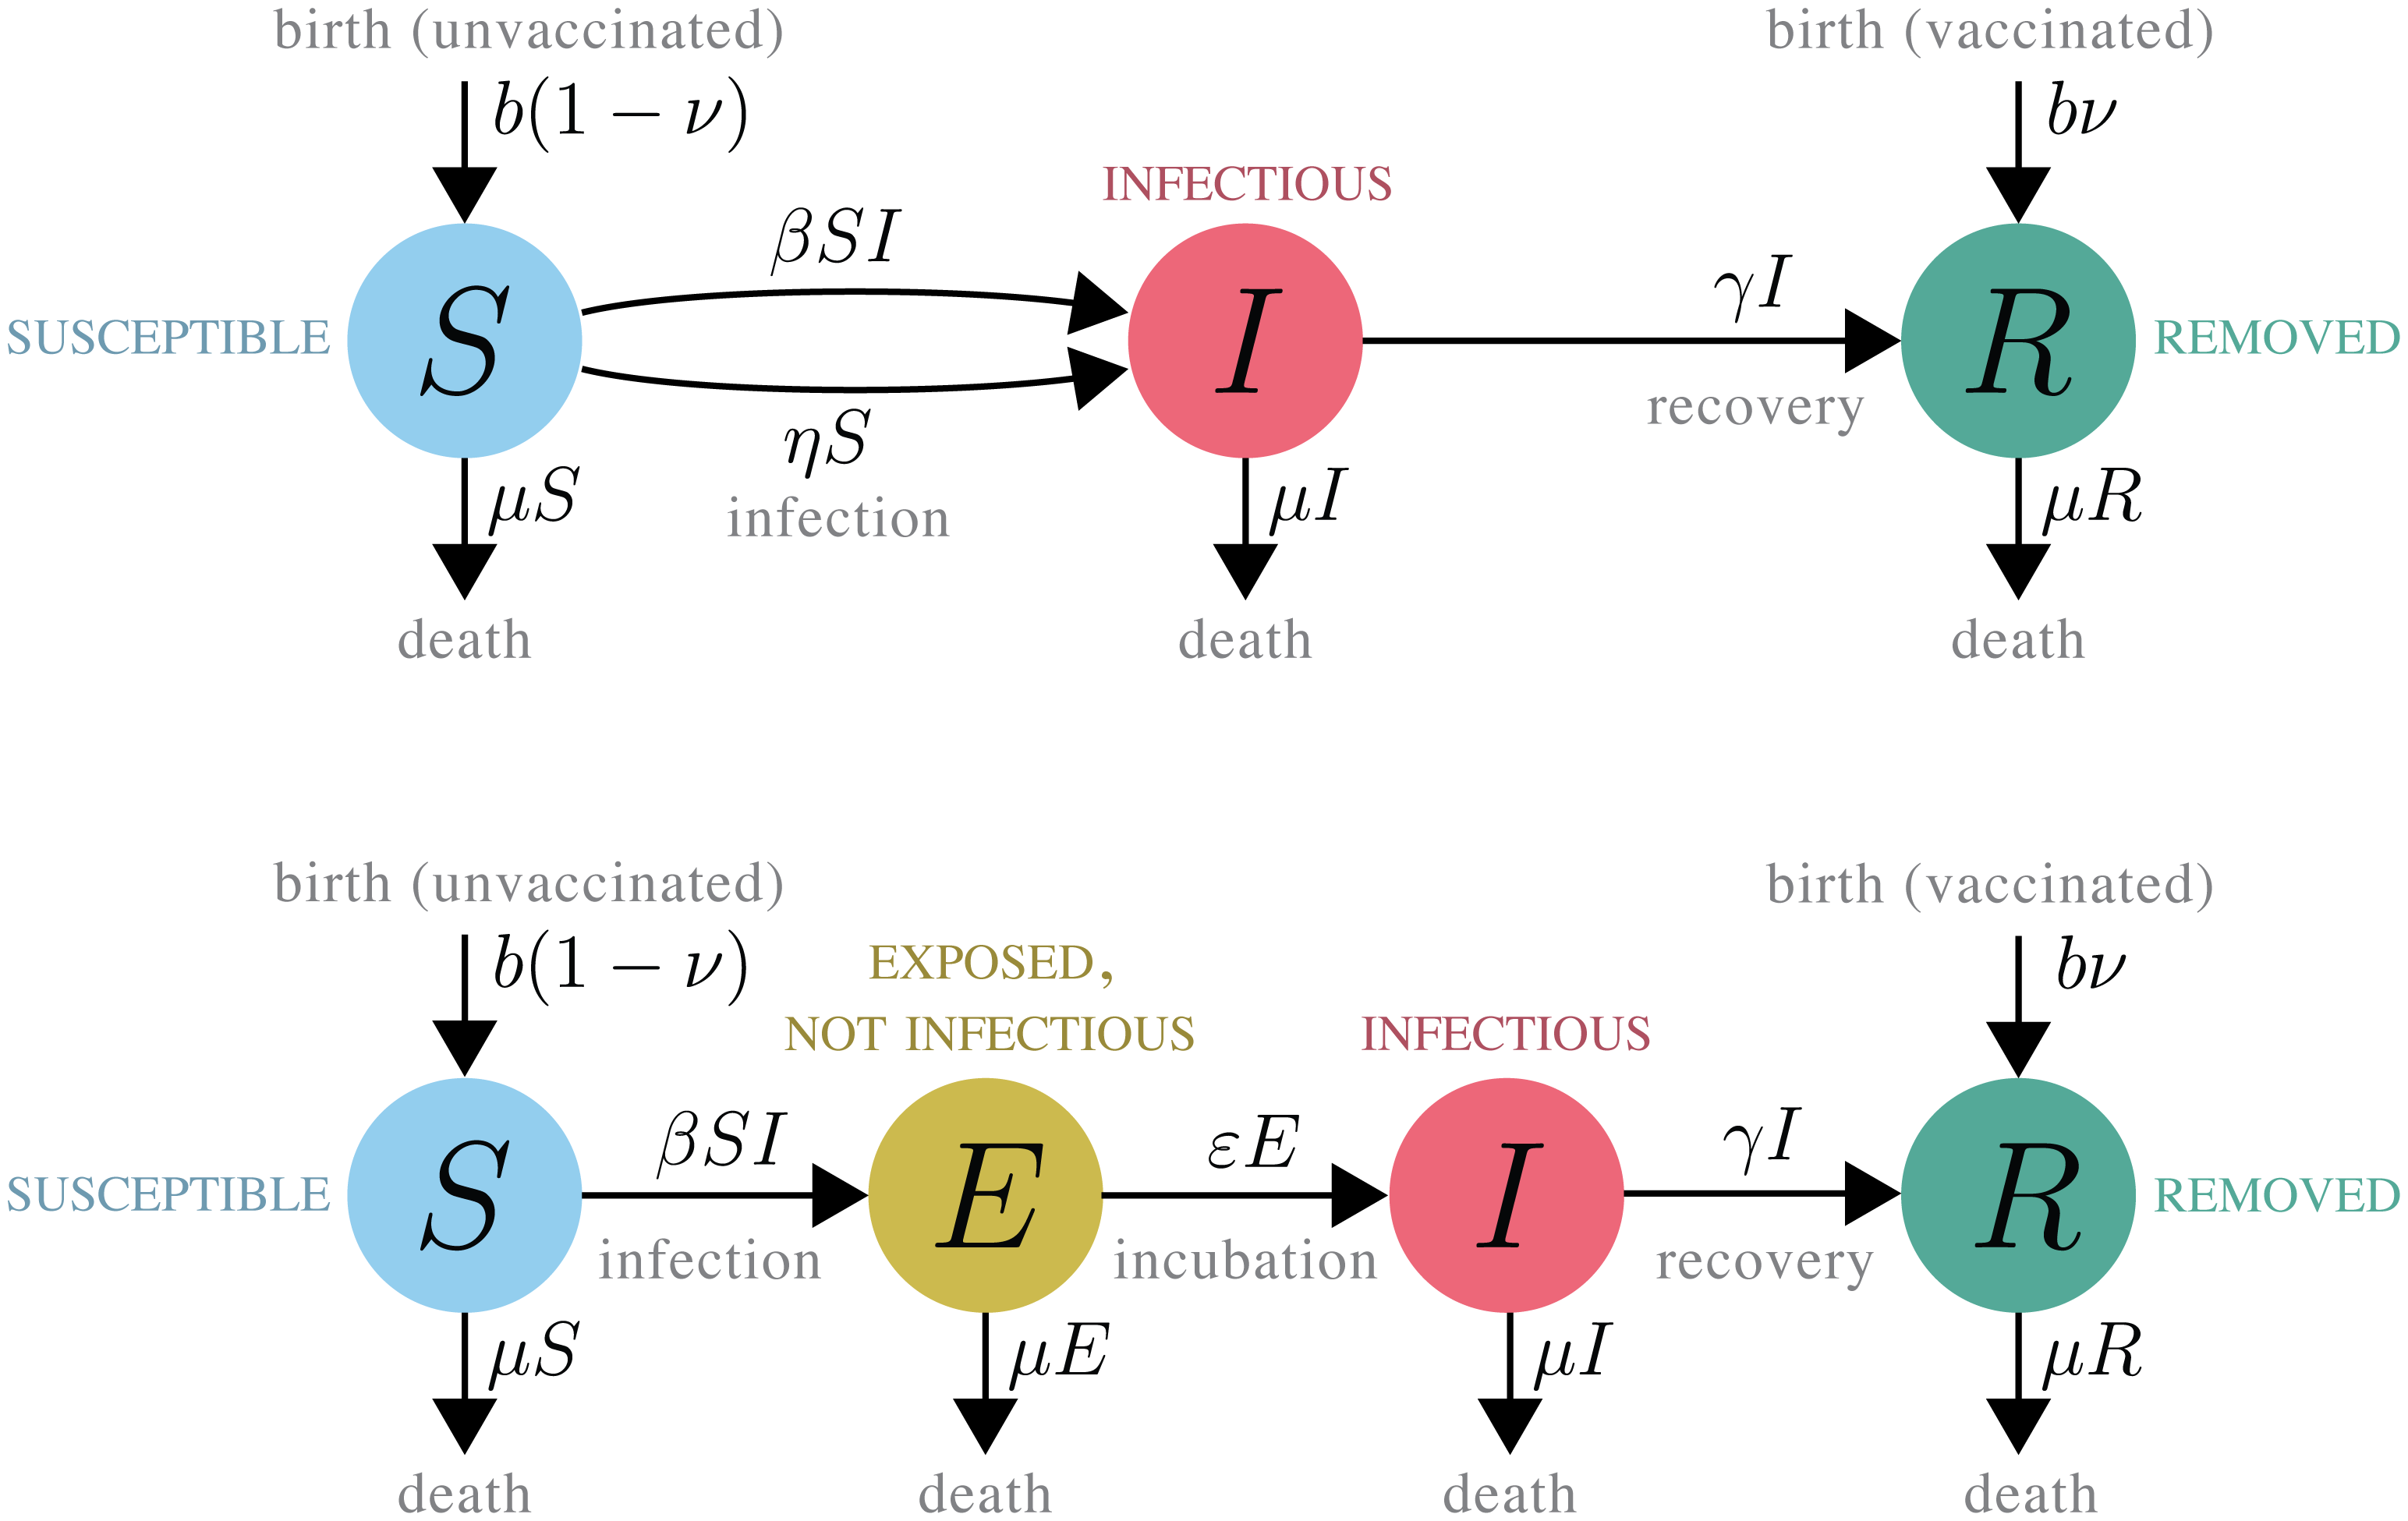

* β - a parameter controlling how much the disease can be transmitted through exposure
* γ - a parameter expressing how much the disease can be recovered in a specific period
* D - the average days to recover from infectious
* R0 - parameter to express the nature of the disease

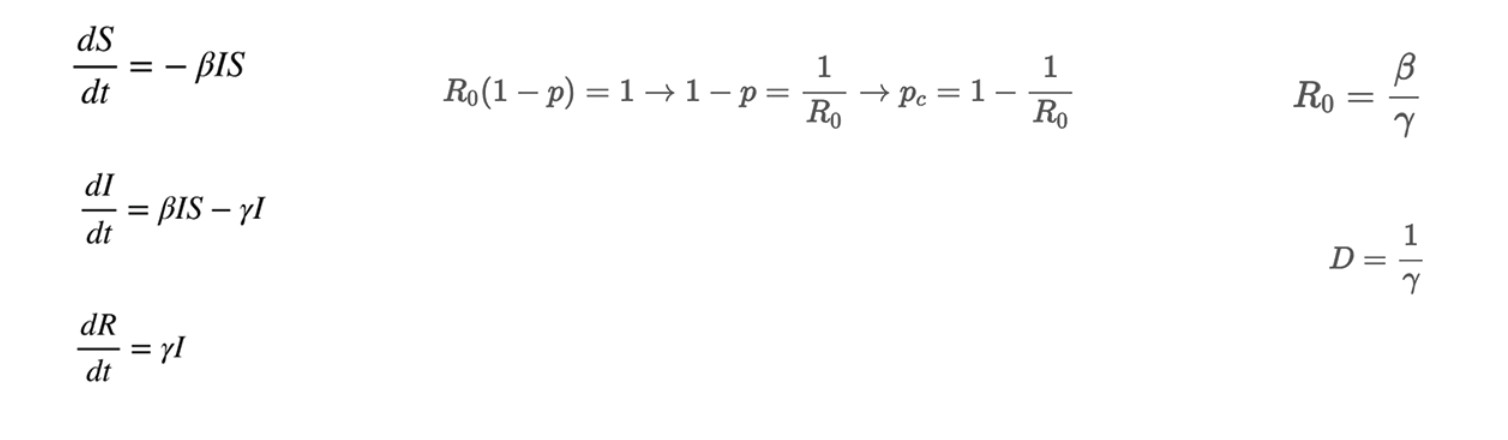

In [ ]:
#Arranging the data set as needed for the SIR model

df_train_pop.head(5)

In [ ]:
df_fin_selc = df_train_pop[['Province_State','Country_Region','Date','ConfirmedCases','Fatalities','Day_num','Day','Month','Year','Population']]

In [ ]:
df_fin_selc[df_fin_selc['Date']=='2020-03-25'].head(5)

In [ ]:
df_fin_selc['I'] = df_fin_selc['ConfirmedCases']-df_fin_selc['Fatalities']
df_fin_selc['R'] = df_fin_selc['Fatalities']
df_fin_selc['S'] = df_fin_selc['Population']-df_fin_selc['ConfirmedCases']
df_SIR = df_fin_selc[['Province_State','Country_Region','Population','Day_num','S','I','R']].reindex()
df_SIR[df_SIR['Country_Region'] == 'Italy'].tail(5)

In [ ]:
df_SIR[df_SIR['Country_Region']=='United Kingdom'].plot(x='Day_num',y= ['I','R'],kind = 'line')

Classmethod and staticmethod :
[https://stackoverflow.com/questions/136097/difference-between-staticmethod-and-classmethod](http://)

In [ ]:
import numpy as np
from scipy.integrate import odeint
from scipy import integrate, optimize

In [ ]:
def SIR_testmodel(y,t,bta,gmma):
    S, I, R = y
    
    dS_dt = -1*bta*I*S/N
    dI_dt = (bta*I*S/N) - gmma*I
    dR_dt = gmma*I
    
    return ([dS_dt, dI_dt, dR_dt])

In [ ]:
#defining initial conditions

N = 1
S00 = 0.9
I00 = 0.1
R00 = 0.0
bta = 0.35
gmma = 0.1

t = np.linspace(0,100,1000)

sol = odeint(SIR_testmodel,[S00,I00,R00],t,args = (bta,gmma))
sol = np.array(sol)

In [ ]:
#plotting results

plt.figure(figsize=(6,4))
plt.plot(t, sol[:,0],label = "S(t)")
plt.plot(t, sol[:,1],label = "I(t)")
plt.plot(t, sol[:,2],label = "R(t)")
plt.legend()
plt.show()

### Fitting the SIR model with real data

### Italy

In [ ]:
Italy_SIR_df = df_SIR[df_SIR['Country_Region']=='Italy']
#covid_pop_sel[covid_pop_sel['Country.Region']=='Italy']
Italy_SIR_df = Italy_SIR_df.reset_index(drop = True)
Italy_SIR_df.tail(5)

In [ ]:
display(covid_pop_sel[covid_pop_sel['Country.Region']=='Italy'])

In [ ]:
Country_Dates[Country_Dates['Country_Region'] == 'Italy']

In [ ]:
cond1 = Italy_SIR_df.I >= 1
test = Italy_SIR_df['Day_num'][(cond1)]
test
Italy_SIR_df.iloc[:10]

In [ ]:
Italy_S = Italy_SIR_df['S']
Italy_I = Italy_SIR_df['I']
Italy_R = Italy_SIR_df['R']

Italy_s = np.array(Italy_S, dtype=float)
Italy_i = np.array(Italy_I, dtype=float)
Italy_r = np.array(Italy_R, dtype=float)

display(Italy_s[9],Italy_i[9], Italy_r[9])

In [ ]:
def SIR_model(y,t,beta,gamma):
    S, I, R = y
    N = 60480000
    dS_dt = -1*beta*I*S/N
    dI_dt = (beta*I*S/N) - gamma*I
    dR_dt = gamma*I
    
    return ([dS_dt, dI_dt, dR_dt])

def fit_odeint(x, beta, gamma):
    return integrate.odeint(SIR_model, (S0, I0, R0), x, args=(beta, gamma))[:,1]

In [ ]:
xdata = Italy_SIR_df.Day_num
ydata = Italy_i
xdata = np.array(xdata, dtype=float)

S0 = 60479998.0
I0 = 2.0
R0 = 0
y = S0, I0, R0

popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata)
fitted = fit_odeint(xdata, *popt)

In [ ]:
plt.plot(xdata, ydata, 'o')
plt.plot(xdata, fitted)
plt.title("Fit of SIR model for Italy infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

### Italy - Using the updated data set with Recovered Count

In [ ]:
#I am using the new data set with Recovered details included as I am getting gamma and beta values more than 1
#this is the same above data set with more details incorporated like Recovered Count and longutude latitude details

comp_df = pd.read_csv('../input/corona-virus-report/covid_19_clean_complete.csv')
comp_df.head(5)

In [ ]:
comp_df['Province/State'].fillna("None", inplace=True)

#Checking null values
comp_df[comp_df.iloc[:,0:].isnull().any(axis = 1)].iloc[:,0:].head()

In [ ]:
comp_df['Date'] = pd.to_datetime(comp_df['Date'])

In [ ]:
#covid_pop_sel 
covid_pop_sel.loc[covid_pop_sel['Country.Region']=='Korea, South', 'Country.Region'] = 'South Korea'
comp_df_pop = comp_df.merge(covid_pop_sel, left_on = ['Country/Region','Province/State'], right_on = ['Country.Region','Province.State'], how = 'left')
comp_df_pop.tail(3)

In [ ]:
comp_pop_sel = comp_df_pop[['Province/State','Country/Region','Date','Confirmed','Deaths','Recovered','Population']]

In [ ]:
comp_pop_sel['Country/Region'][comp_pop_sel['Population'].isnull()].unique()

In [ ]:
#comp_df[comp_df['Country/Region'].str.match('Canada')]
#covid_pop_sel[covid_pop_sel['Country.Region'].str.match('Canada')].head(2)

In [ ]:
missings_count = {col:comp_pop_sel[col].isnull().sum() for col in comp_pop_sel.columns}
missings = pd.DataFrame.from_dict(missings_count, orient='index')
print(missings.nlargest(30, 0))

In [ ]:
#treating null values
comp_pop_sel['Population'] = comp_pop_sel['Population'].fillna(0)

In [ ]:
comp_df_Italy = comp_pop_sel[comp_pop_sel['Country/Region']=='Italy']
comp_df_Italy = comp_df_Italy.reset_index(drop = True)
comp_df_Italy.tail(5)

In [ ]:
comp_df_Italy['Day_num'] = preprocessing.LabelEncoder().fit_transform(comp_df_Italy.Date)
comp_df_Italy.tail(3)

In [ ]:
comp_df_Italy['R'] = comp_df_Italy['Deaths']+comp_df_Italy['Recovered']
comp_df_Italy['I'] = comp_df_Italy['Confirmed']- comp_df_Italy['R']
comp_df_Italy['S'] = comp_df_Italy['Population']-comp_df_Italy['I']-comp_df_Italy['R']
comp_df_Italy.tail(3)

In [ ]:
comp_df_Italy_S = comp_df_Italy['S']
comp_df_Italy_I = comp_df_Italy['I']
comp_df_Italy_R = comp_df_Italy['R']

comp_df_Italy_s = np.array(comp_df_Italy_S, dtype=float)
comp_df_Italy_i = np.array(comp_df_Italy_I, dtype=float)
comp_df_Italy_r = np.array(comp_df_Italy_R, dtype=float)

display(comp_df_Italy_s[9],comp_df_Italy_i[9], comp_df_Italy_r[9])

In [ ]:
N = 60480000
S0 = 60479998
I0 = 2
R0 = 0

xdata = comp_df_Italy.Day_num
xdata = np.array(xdata, dtype=float)
ydata = comp_df_Italy_i
ydata = np.array(ydata, dtype=float)

popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata)
fitted = fit_odeint(xdata, *popt)

plt.plot(xdata, ydata, 'o')
plt.plot(xdata, fitted)
plt.title("Fit of SIR model for Italy infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

Insight : Althougth the curve is fitting for data before April 1, the curve is not fitting to data after April 1st. So I am going to try XGBOOST classifier for this. XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.

### Trying with XGBoost Algorithm

In [ ]:
df_train = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-4/train.csv')
df_test = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-4/test.csv')
df_subm = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-4/submission.csv')

In [ ]:
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

In [ ]:
df_train.rename(columns={'Country_Region':'Country'}, inplace=True)
df_train.rename(columns={'Province_State':'State'}, inplace=True)
df_train['Date'] = pd.to_datetime(df_train['Date'], infer_datetime_format=True)

df_test.rename(columns={'Country_Region':'Country'}, inplace=True)
df_test.rename(columns={'Province_State':'State'}, inplace=True)
df_test['Date'] = pd.to_datetime(df_test['Date'], infer_datetime_format=True)

In [ ]:
#confirmed cases
y1_df_Train = df_train.iloc[:, -2]
#fatalities
y2_df_Train = df_train.iloc[:, -1]

NOVAL = "NOVAL"
def handlenullstate(State, Country):
    if State == NOVAL: return Country
    return State

In [ ]:
#Data Cleansing and enrichment

df_train['State'].fillna(NOVAL, inplace=True)
df_train['State'] = df_train.loc[:, ['State', 'Country']].apply(lambda x : handlenullstate(x['State'], x['Country']), axis=1)

df_train.loc[:, 'Date'] = df_train.Date.dt.strftime("%m%d")
df_train["Date"]  = df_train["Date"].astype(int)

df_test['State'].fillna(NOVAL, inplace=True)
df_test['State'] = df_test.loc[:, ['State', 'Country']].apply(lambda x : handlenullstate(x['State'], x['Country']), axis=1)

df_test.loc[:, 'Date'] = df_test.Date.dt.strftime("%m%d")
df_test["Date"]  = df_test["Date"].astype(int)

df_test.head()

In [ ]:
covid_pop_taken = covid_pop[['Province.State','Country.Region','Population']]

In [ ]:
covid_pop_taken.rename(columns={'Province.State':'State'}, inplace=True)
covid_pop_taken.rename(columns={'Country.Region':'Country'}, inplace=True)

In [ ]:
covid_pop_taken['State'].fillna("None", inplace=True)
NOVAL = 'None'
covid_pop_taken['State'] = covid_pop_taken.loc[:, ['State', 'Country']].apply(lambda x : handlenullstate(x['State'], x['Country']), axis=1)
covid_pop_taken.head(3)

In [ ]:
df_train_copy2 = df_train.copy()
df_test_copy2 = df_test.copy()
df_test.head(3)

In [ ]:
df_train_co_pop = df_train.merge(covid_pop_taken, left_on = ['Country','State'], right_on = ['Country','State'], how = 'left')
df_test_co_pop = df_test.merge(covid_pop_taken, left_on = ['Country','State'], right_on = ['Country','State'], how = 'left')
df_test_co_pop.head(5)

In [ ]:
df_train_co_pop['Country'][df_train_co_pop['Population'].isnull()].unique()

In [ ]:
#covid_pop_sel.loc[covid_pop_sel['Country']=='Korea, South', 'Country.Region'] = 'South Korea'

#### Preprocessing

In [ ]:
df_train_co_pop[['Population']] = preprocessing.scale(df_train_co_pop[['Population']])
df_test_co_pop[['Population']] = preprocessing.scale(df_test_co_pop[['Population']])

In [ ]:
df_train_co_pop.head(3)

In [ ]:
df_train = df_train_co_pop 
df_test = df_test_co_pop 

In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

df_train.Country = le.fit_transform(df_train.Country)
df_train['State'] = le.fit_transform(df_train['State'])
df_train.Country = le.fit_transform(df_train.Country)

df_test.Country = le.fit_transform(df_test.Country)
df_test['State'] = le.fit_transform(df_test['State'])

df_test.head()

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn import preprocessing

le = preprocessing.LabelEncoder()

from xgboost import XGBRegressor

countries = df_train.Country.unique()

In [ ]:
xout = pd.DataFrame({'ForecastId': [], 'ConfirmedCases': [], 'Fatalities': []})

for country in countries:
    states = df_train.loc[df_train.Country == country, :].State.unique()
    for state in states:
        #trian
        x_train_CS = df_train.loc[(df_train.Country == country) & (df_train.State == state), ['State', 'Country', 'Date', 'ConfirmedCases', 'Fatalities','Population']]
        y1_train_CS = x_train_CS.loc[:, 'ConfirmedCases']
        y2_train_CS = x_train_CS.loc[:, 'Fatalities']
        x_train_CS = x_train_CS.loc[:, ['State', 'Country', 'Date','Population']]
        x_train_CS.Country = le.fit_transform(x_train_CS.Country)
        x_train_CS['State'] = le.fit_transform(x_train_CS['State'])
        
        #test
        x_test_CS = df_test.loc[(df_test.Country == country) & (df_test.State == state), ['State', 'Country', 'Date', 'ForecastId','Population']]
        x_test_CS_Id = x_test_CS.loc[:, 'ForecastId']
        x_test_CS = x_test_CS.loc[:, ['State', 'Country', 'Date','Population']]
        x_test_CS.Country = le.fit_transform(x_test_CS.Country)
        x_test_CS['State'] = le.fit_transform(x_test_CS['State'])
        
        xmodel1 = XGBRegressor(n_estimators=1000)
        xmodel1.fit(x_train_CS, y1_train_CS)
        y1_xpred = xmodel1.predict(x_test_CS)
        
        xmodel2 = XGBRegressor(n_estimators=1000)
        xmodel2.fit(x_train_CS, y2_train_CS)
        y2_xpred = xmodel2.predict(x_test_CS)
        
        xdata = pd.DataFrame({'ForecastId': x_test_CS_Id, 'ConfirmedCases': y1_xpred, 'Fatalities': y2_xpred})
        xout = pd.concat([xout, xdata], axis=0)


In [ ]:
xout.ForecastId = xout.ForecastId.astype('int')
xout['ConfirmedCases'] = round(xout['ConfirmedCases'],1)
xout['Fatalities'] = round(xout['Fatalities'],1)
display(xout.head())

In [ ]:
#xout['ForecastId'] = xout['ForecastId'].apply(int)
xout['ConfirmedCases'] = xout['ConfirmedCases'].apply(int)
xout['Fatalities'] = xout['Fatalities'].apply(int)

In [ ]:
xout.dtypes

In [ ]:
xout = xout.drop_duplicates()
xout.reindex()

In [ ]:
xout.to_csv('submission.csv', index=False)